# SBS SMK Test

This notebook should be used as a test for ensuring correct SBS image loading and processing before running a snakemake workflow.
Change the parameters specified at SET PARAMETERS cells and run the notebook to ensure the functions work as intended.

## Imports

In [1]:
from pathlib import Path

from IPython.display import display
from microfilm import microplot
from microfilm.microplot import Micropanel
import matplotlib.pyplot as plt
import matplotlib

from ops.sbs_smk import Snake_sbs
import ops
from ops.imports_ipython import *
from ops.qc import *

## SET PARAMETERS

The following cell contains crucial variables that need to be set according to your specific experimental setup and data organization. Please review and modify these variables as needed before proceeding with the analysis.

### Loading, aligning, detecting candiate reads

- `SBS_CYCLES`: The number and order of SBS cycles
- `WELLS` and `TILES`: The well and tile you want to analyze (for this notebook, we're using one well/tile combination for testing)
- `CHANNELS` and `preprocess_pattern`: The channel names and file naming conventions
- `DISPLAY_RANGES` and `LUTS`: The display ranges and color schemes (Look-Up Tables) for your image data

### Illumination correction and segmentation

- `SEGMENTATION_CYCLE`: Determines which cycle is used for segmentation and illumination correction. Typically, this is set to the cycle with the brightest or clearest signal for cell boundaries, but in the case that we have just taken one multichannel image, it is set to that.
- `DAPI_INDEX`: The index of the DAPI channel in your image stack (0-indexed). Typically 0 for the DAPI channel from sequencing.
- `CYTO_CHANNEL`: The index of the cytoplasmic channel in your image stack (0-indexed). Typically the channel that best outlines cell boundaries, usually base C.
- `NUCLEI_DIAMETER`: Expected cell nuclei diameter. Used by CellPose during segmentation.
- `CELL_DIAMETER`: Expected cell cytoplasm diameter. Used by CellPose during segmentation.
- `CYTO_MODEL`: CellPose cyto model to use during segmentation.

For Cellpose segmentation, we strongly suggest calibrating via the Cellpose GUI. Follow these steps:

1. Open a terminal window
2. SSH onto fry: `ssh -Y username@fry.wi.mit.edu`
3. Activate a conda environment with cellpose[gui]: `conda activate ops_viewing`
4. Launch Cellpose: `python -m cellpose`
5. Open the prepared Cellpose image: `sbs_1/tif/10X_well_Tile-nn.prepared_cellpose.tif`
6. Calibrate cyto3 model:
   - For cell diameter: use chan to segment = 2, chan2 = 3
   - For nuclei diameter: use chan to segment = 3, chan2 = 0

Note: You may want to adjust the diameter parameters and segment to test if you feel like you are capturing too little or too much area for either of the two masks.

### Extract base intensity, call reads, assign to cells

- `DF_DESIGN_PATH`: The path to your guide RNA design file
- `THRESHOLD_READS`: The intensity threshold for detecting sequencing reads. Adjust this value based on the signal-to-noise ratio in your data.
- `BASES`: The order of bases used in your sequencing. This should match the order of channels in your sequencing data.
The following cell contains an important parameter for filtering sequencing reads based on their quality. Please review and adjust this variable based on your specific experimental needs before proceeding with the analysis.
- `Q_MIN`: The minimum Levenshtein distance allowed between a read and its closest barcode match. A value of 0 means only perfect matches are accepted, while higher values allow for more mismatches. A lower value increases stringency but may reduce the number of accepted reads, while a higher value allows for more reads but may increase false positives.

Ensure these variables accurately reflect your experimental setup to guarantee correct data processing and analysis.

In [2]:
# Output directory for notebook results
INPUT_FILES_DIR = "input/"
OUTPUT_FILES_DIR = "output/"

# Define lists of cycles
SBS_CYCLES = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
CYCLE_FILES = [1] + [4,]*(len(SBS_CYCLES)-1)

# Set wells and tiles (in this notebook, one well / tile combination to test on)
WELLS = "A1"
TILES = 50
WILDCARDS = dict(well=WELLS, tile=TILES)

# Define channels
CHANNELS = ['DAPI-CY3_30p_545-A594_30p-CY5_30p-CY7_30p']+[['CY3_30p_545', 'A594_30p', 'CY5_30p', 'CY7_30p']]*(len(SBS_CYCLES)-1)

# Define the file pattern
PREPROCESS_PATTERN = '10X_c{cycle}-SBS-{cycle}_{well}_Tile-{tile}.sbs.Channel-{channel}.tif'

# Define display ranges for different channels, recognized by ImageJ
DISPLAY_RANGES = [
    [500, 15000],  # Range for DAPI channel
    [100, 10000],  # Range for CY3 channel
    [100, 10000],  # Range for A594 channel
    [200, 25000],  # Range for CY5 channel
    [200, 25000],  # Range for CY7 channel
]

# Define LUTs (Lookup Tables) for different channels
LUTS = [
    ops.io.GRAY,  # Lookup table for DAPI channel
    ops.io.GREEN,  # Lookup table for CY3 channel
    ops.io.RED,  # Lookup table for A594 channel
    ops.io.MAGENTA,  # Lookup table for CY5 channel
    ops.io.CYAN,  # Lookup table for CY7 channel
]

# Define cycle to use for segmentation, -1 for last cycle
SEGMENTATION_CYCLE = -1

# Define illumination correction file for use in segmentation
ICF_FILE_PATH = "input/10X_c1-SBS-1_A1.sbs.illumination_correction.tif"

# Define Cellpose segmentation parameters
DAPI_INDEX = 0
CYTO_CHANNEL = 4

# Parameters for cellpose method
NUCLEI_DIAMETER = 10.8  # Calibrate with Cellpose
CELL_DIAMETER = 18.4    # Calibrate with Cellpose
CYTO_MODEL = "cyto3"

# Define parameters for extracting bases
DF_DESIGN_PATH = "input/pool10_design.csv"
THRESHOLD_READS = 315
BASES = "GTAC"

# Define parameters for read mapping
Q_MIN = 0

In [3]:
# Function to generate file paths
def generate_file_paths(input_files_dir, preprocess_pattern, well, tile, sbs_cycles):
    file_paths = []

    # First cycle (all channels)
    cycle_file_name = preprocess_pattern.format(cycle=SBS_CYCLES[0], well=well, channel=CHANNELS[0], tile=tile)
    file_path = f"{input_files_dir}{cycle_file_name}"
    file_paths.append(file_path)
    
    # Subsequent cycles (4 channels each)
    for cycle in range(1, len(SBS_CYCLES)):
        cycle_file_names = [preprocess_pattern.format(cycle=SBS_CYCLES[cycle], well=well, channel=channel, tile=tile) 
                       for channel in CHANNELS[cycle]]
        for cycle_file_name in cycle_file_names:
            file_path = f"{input_files_dir}{cycle_file_name}"
            file_paths.append(file_path)
    
    return file_paths

# Custom function to create segmentation colormap
def random_cmap(alpha=0.5, num_colors=256):
    """Create random colormap for segmentation"""
    colmat = np.random.rand(num_colors,4)
    colmat[:,-1] = alpha
    colmat[0, :] = [0, 0, 0, 1]  # Set the first color to black with full transparency
    cmap = matplotlib.colors.ListedColormap(colmat)
    return cmap

In [4]:
print("Loading input images...")
input_image_paths = generate_file_paths(
    INPUT_FILES_DIR, PREPROCESS_PATTERN, WELLS, TILES, SBS_CYCLES
)
input_images = [read(f) for f in input_image_paths]
print(f"Input images loaded: {len(input_images)}")
# parse description from input image
description = parse(input_image_paths[0])
keys_to_remove = ["cycle", "tag", "file"]
for key in keys_to_remove:
    description.pop(key, None)
print(f"Input file description: {description}")

Loading input images...
Input images loaded: 41
Input file description: {'subdir': 'input', 'mag': '10X', 'well': 'A1', 'tile': '50', 'ext': 'tif'}


Aligning input images...
(5, 1480, 1480)
(4, 1480, 1480)
Shape of SBS images aligned across cycles: (11, 5, 1480, 1480)
Example aligned image for first cycle:


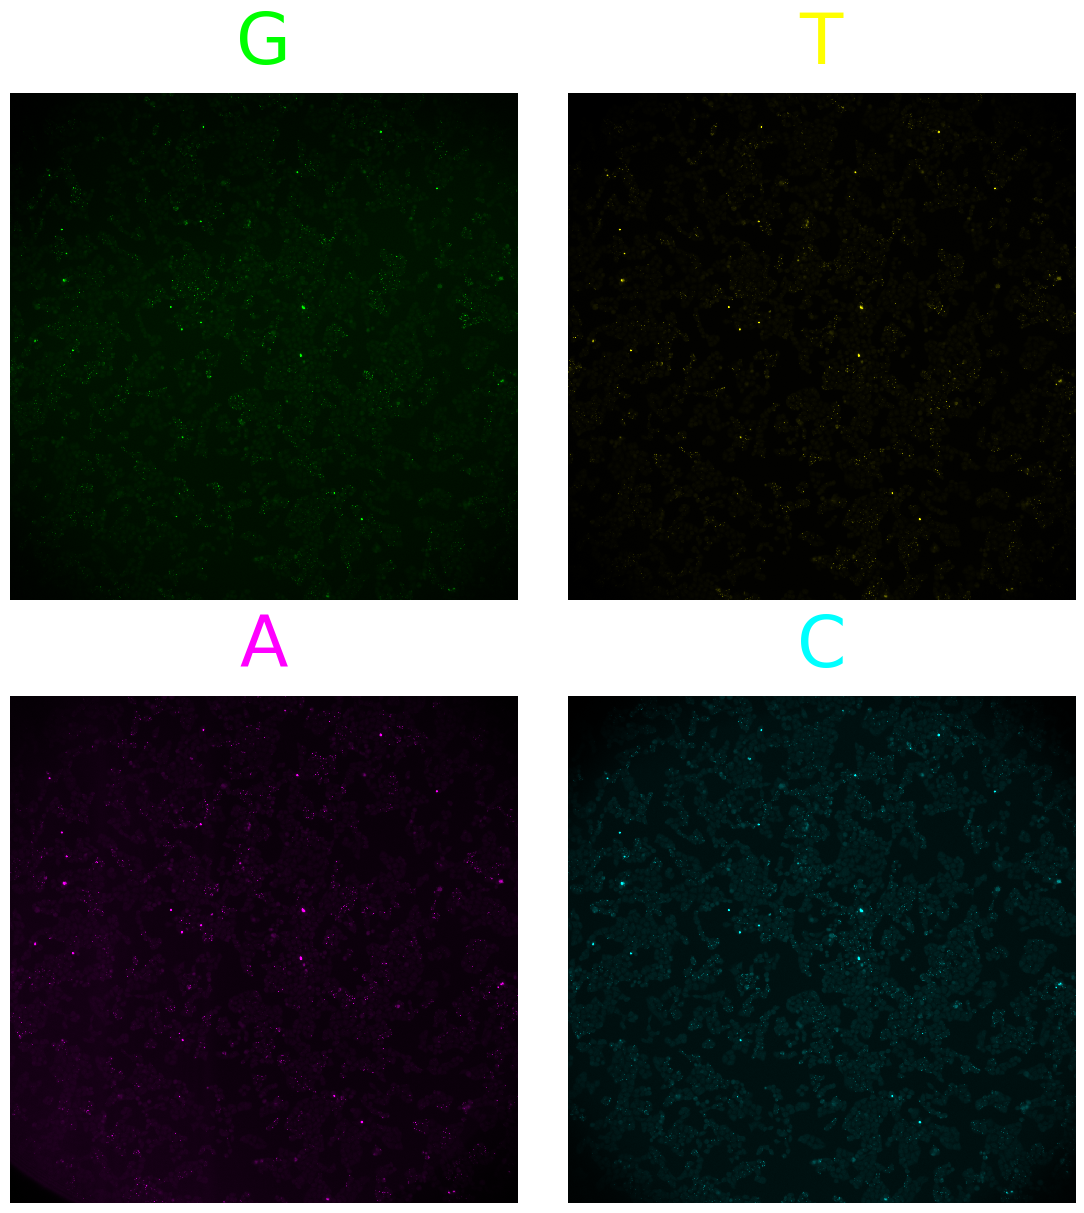

In [5]:
print("Aligning input images...")
# This corresponds to the 'align' rule in Snakemake
aligned = Snake_sbs._align_SBS(
    input_images,
    method="SBS_mean",
    cycle_files=CYCLE_FILES,
    upsample_factor=1,
    n=1,
    keep_extras=True,
)
save(
    name(description, tag="aligned", subdir=OUTPUT_FILES_DIR),
    aligned,
    display_ranges=DISPLAY_RANGES,
    luts=LUTS,
)
# expected dimensions of (CYCLE, CHANNEL, I, J)
print(f"Shape of SBS images aligned across cycles: {aligned.shape}")

print("Example aligned image for first cycle:")
# show aligned for one round
g_aligned_microshow = microplot.Microimage(
    aligned[0, 1, :, :], cmaps="pure_green", channel_names="G"
)
t_aligned_microshow = microplot.Microimage(
    aligned[0, 2, :, :], cmaps="pure_yellow", channel_names="T"
)
a_aligned_microshow = microplot.Microimage(
    aligned[0, 3, :, :], cmaps="pure_magenta", channel_names="A"
)
c_aligned_microshow = microplot.Microimage(
    aligned[0, 4, :, :], cmaps="pure_cyan", channel_names="C"
)
panel = Micropanel(rows=2, cols=2, figscaling=6)
panel.add_element([0, 0], g_aligned_microshow)
panel.add_element([0, 1], t_aligned_microshow)
panel.add_element([1, 0], a_aligned_microshow)
panel.add_element([1, 1], c_aligned_microshow)
panel.add_channel_label()

Detecting candidate reads...
Applying Laplacian-of-Gaussian (LoG) filter...


Computing standard deviation over cycles...
Applying max filter...
Finding peaks...
Example max filtered image for first cycle:


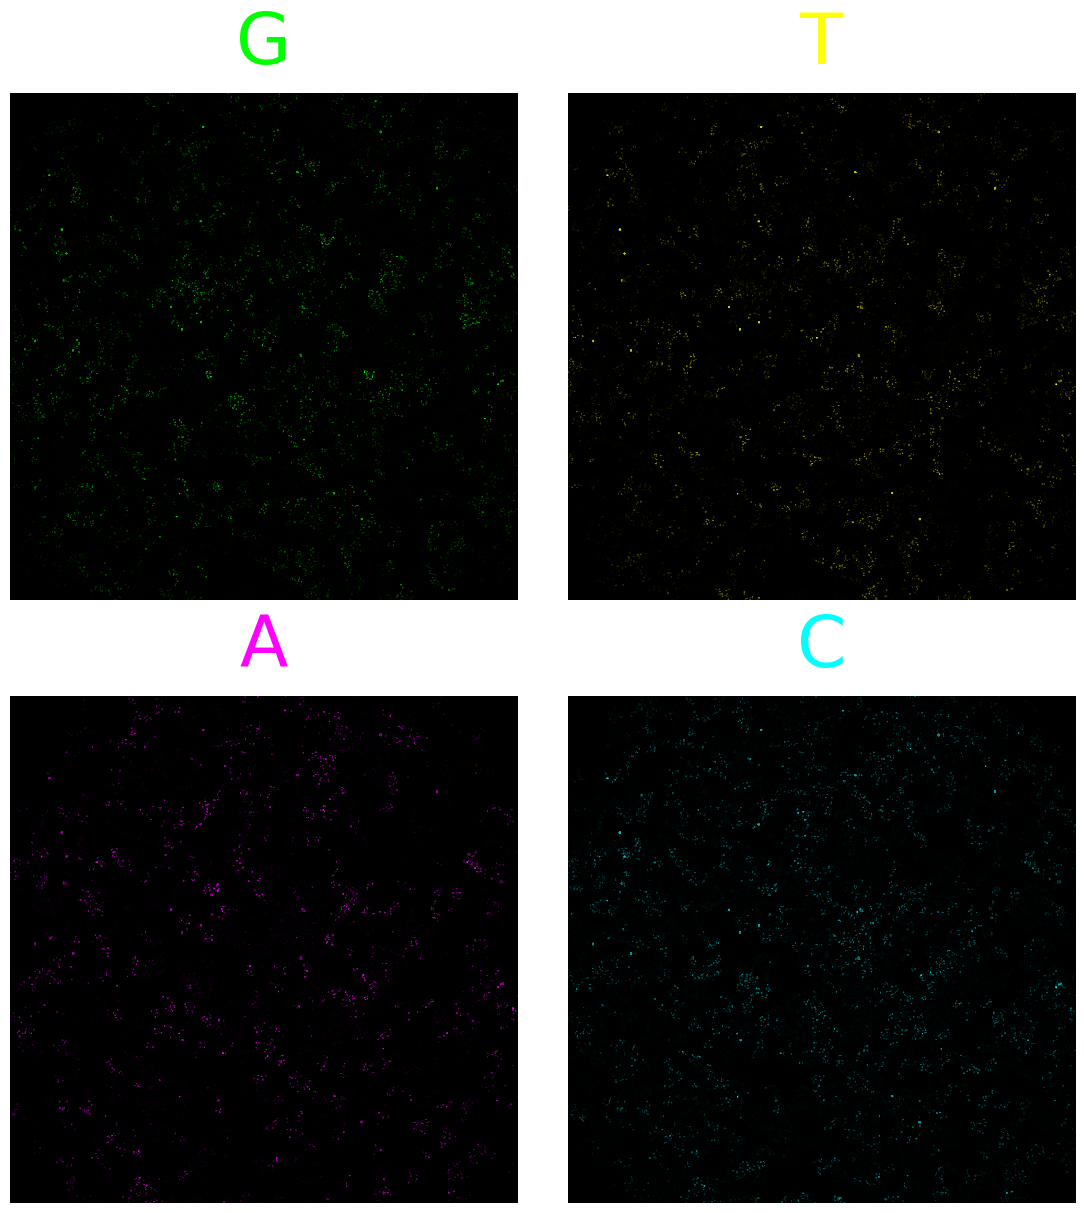

In [6]:
print("Detecting candidate reads...")

print("Applying Laplacian-of-Gaussian (LoG) filter...")
loged = Snake_sbs._transform_log(aligned, skip_index=0)
save(name(description, tag='log', subdir=OUTPUT_FILES_DIR),
     loged, display_ranges=DISPLAY_RANGES, luts=LUTS)

print("Computing standard deviation over cycles...")
std = Snake_sbs._compute_std(loged, remove_index=0)
save(name(description, tag='std', subdir=OUTPUT_FILES_DIR), std)

print("Applying max filter...")
# This corresponds to the 'max_filter' rule in Snakemake
maxed = Snake_sbs._max_filter(loged, width=3, remove_index=0)
save(name(description, tag='maxed', subdir=OUTPUT_FILES_DIR),
     maxed, display_ranges=DISPLAY_RANGES[1:], luts=LUTS[1:])

print("Finding peaks...")
peaks = Snake_sbs._find_peaks(std)
save(name(description, tag='peaks', subdir=OUTPUT_FILES_DIR), peaks)

print("Example max filtered image for first cycle:")
# show max filtered data for one round
g_maxed_microshow = microplot.Microimage(maxed[0, 0, :, :],
                                         cmaps='pure_green',
                                         channel_names='G')
t_maxed_microshow = microplot.Microimage(maxed[0, 1, :, :],
                                         cmaps='pure_yellow',
                                         channel_names='T')
a_maxed_microshow = microplot.Microimage(maxed[0, 2, :, :],
                                         cmaps='pure_magenta',
                                         channel_names='A')
c_maxed_microshow = microplot.Microimage(maxed[0, 3, :, :],
                                         cmaps='pure_cyan',
                                         channel_names='C')
panel = Micropanel(rows=2, cols=2, figscaling=6)
panel.add_element([0, 0], g_maxed_microshow)
panel.add_element([0, 1], t_maxed_microshow)
panel.add_element([1, 0], a_maxed_microshow)
panel.add_element([1, 1], c_maxed_microshow)
panel.add_channel_label()

Applying illumination correction to segmentation cycle image...
Preparing IC segmentation image for CellPose...


/lab/barcheese01/rkern/OpticalPooledScreens/venv_ops/lib/python3.8/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)
/lab/barcheese01/rkern/OpticalPooledScreens/venv_ops/lib/python3.8/site-packages/skimage/util/dtype.py:531: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)


Segmenting IC segmentation image with CellPose...


found 4384 nuclei before removing edges
found 4195 cells before removing edges
found 4288 nuclei before reconciling
found 4122 cells before reconciling


removing edges
reconciling masks with method how=consensus


found 4033 nuclei/cells after reconciling


Number of nuclei segmented: 4033
Number of cells segmented: 4033
Example microplots for DAPI channel and nuclei segmentation:


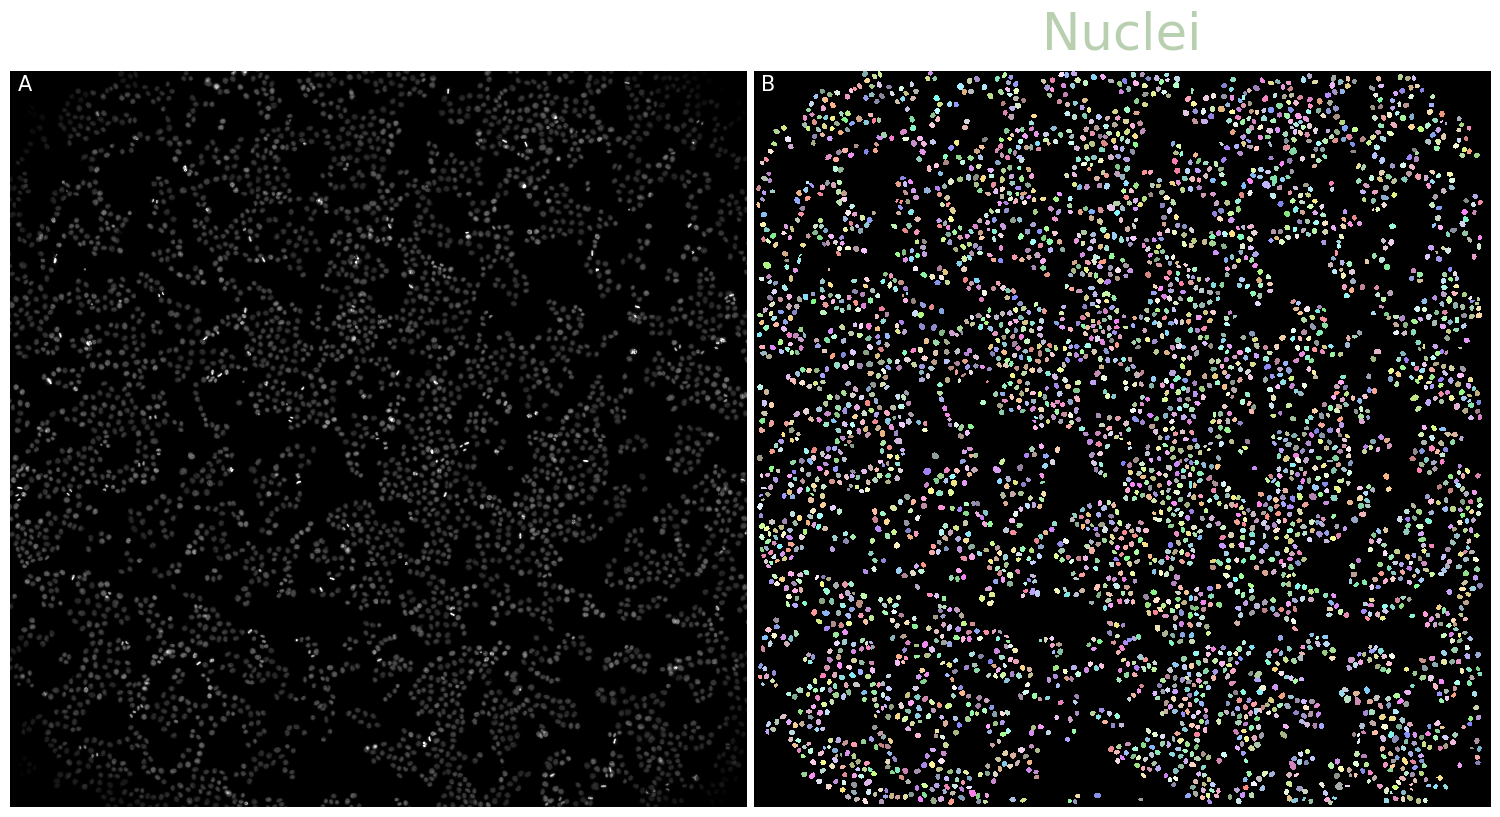

Example microplots for merged channels and cells segmentation:


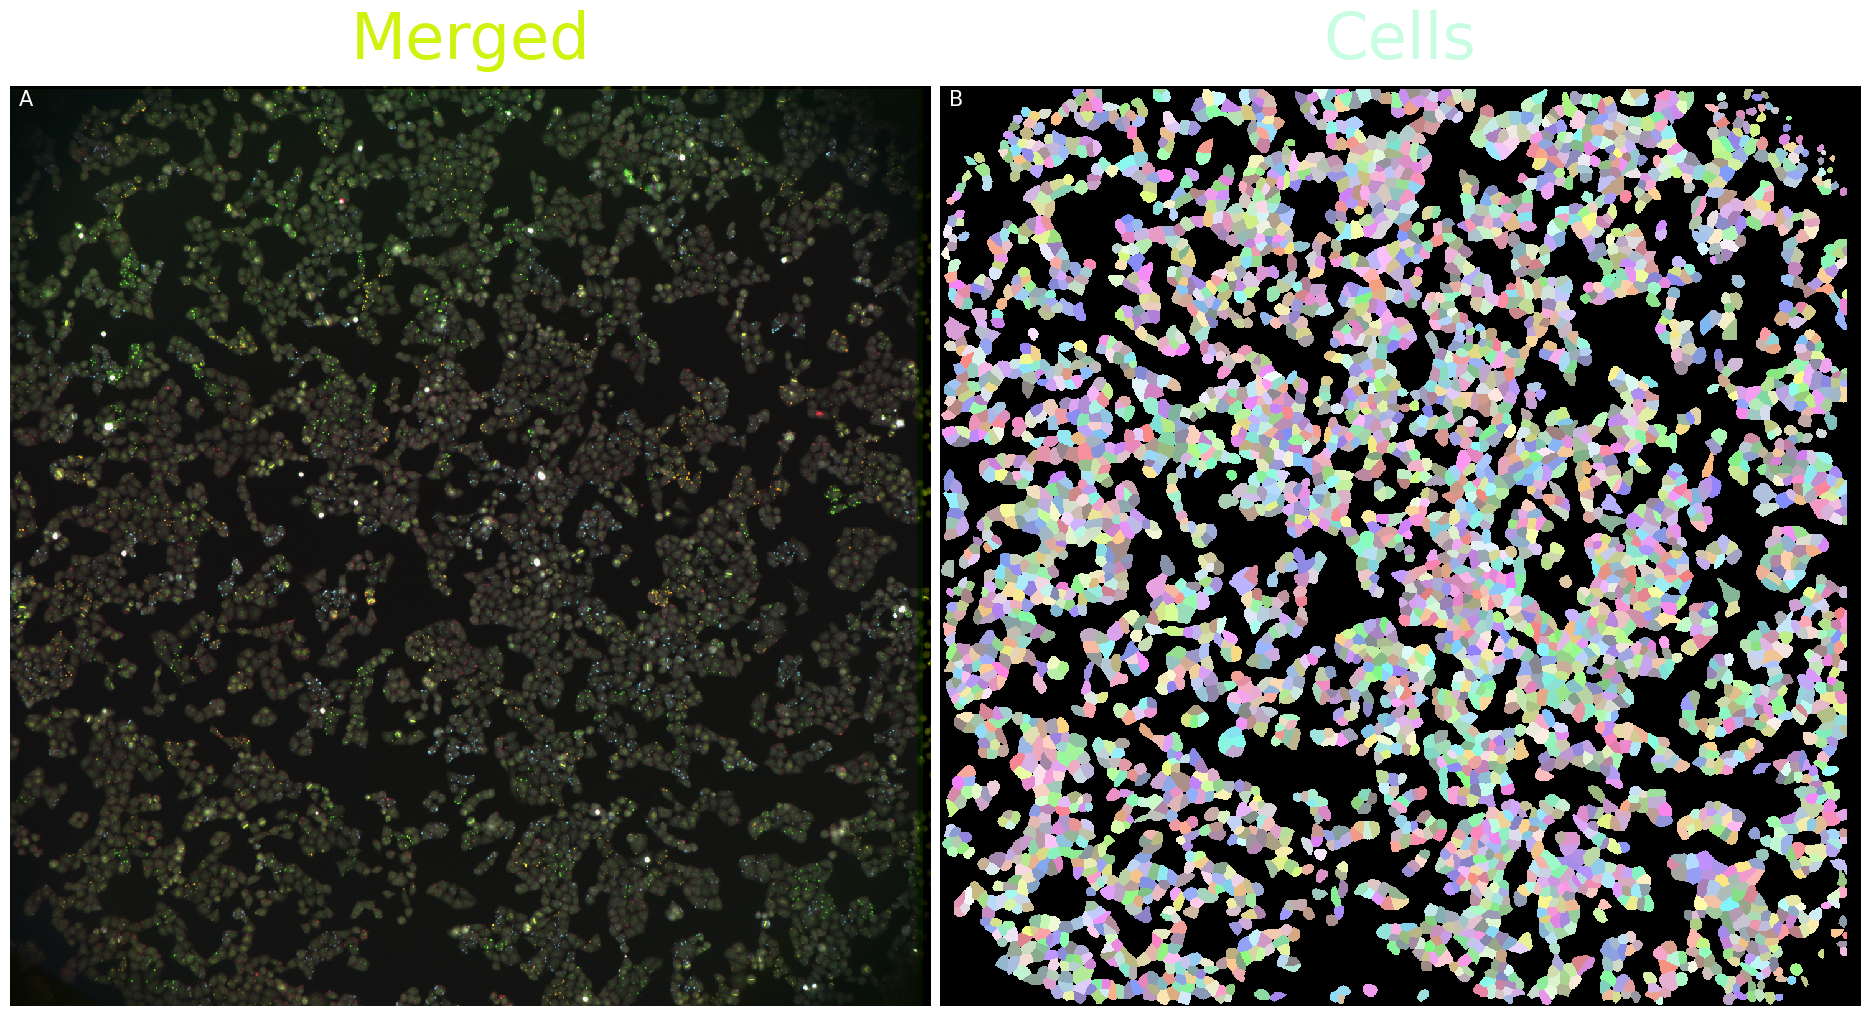

Annotating segmentation on sequencing data...
Example microplot for annotated segementation data:


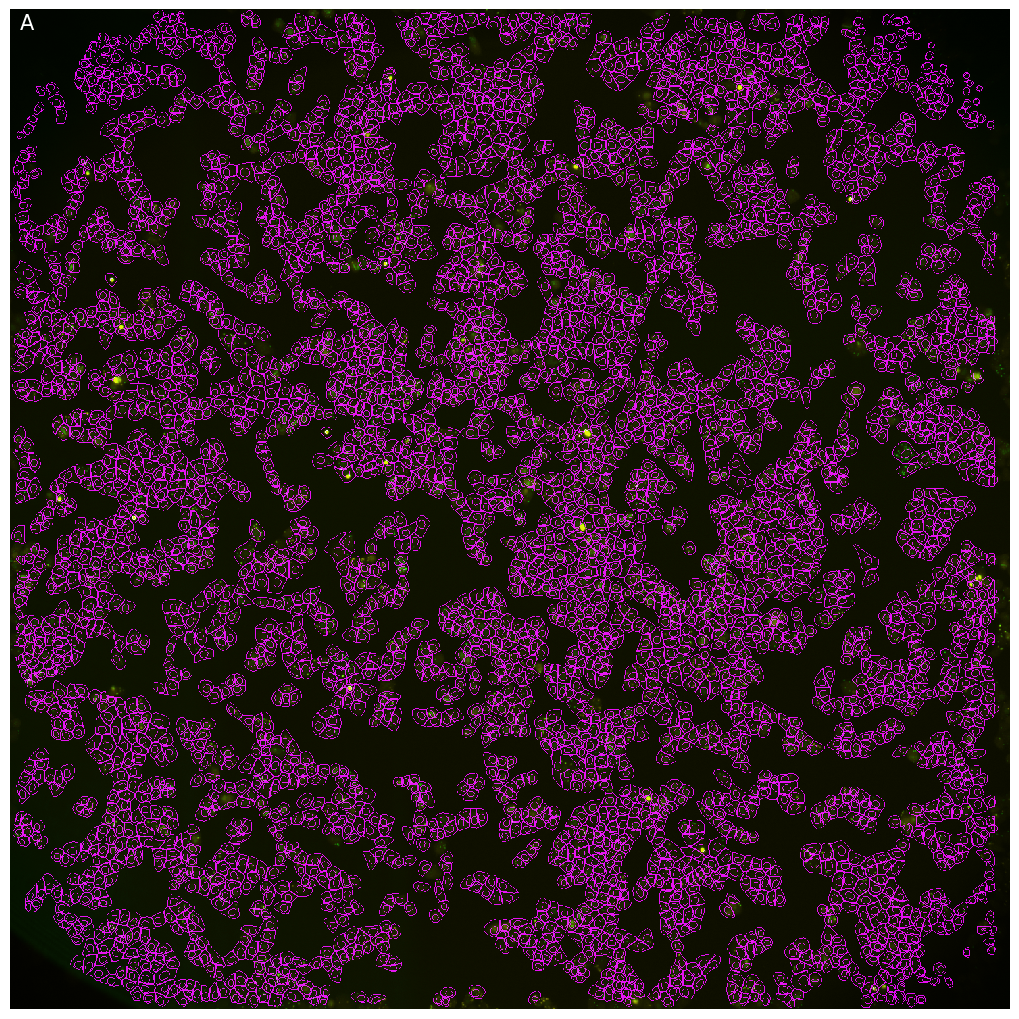

In [7]:
print("Applying illumination correction to segmentation cycle image...")
# Read the illumination correction file
correction_image = read(ICF_FILE_PATH)
ic_segmentation_image = Snake_sbs._apply_illumination_correction(
    aligned[SEGMENTATION_CYCLE], correction=correction_image)
save(name(description, tag='illumination_correction', subdir=OUTPUT_FILES_DIR),
     ic_segmentation_image, display_ranges=DISPLAY_RANGES, luts=LUTS)

print("Preparing IC segmentation image for CellPose...")
cellpose_rgb = Snake_sbs._prepare_cellpose(
    ic_segmentation_image, DAPI_INDEX, CYTO_CHANNEL)
save(name(description, tag='prepared_cellpose',
     subdir=OUTPUT_FILES_DIR), cellpose_rgb)
# note, this process is done during the _segment_cellpose method below as well

print("Segmenting IC segmentation image with CellPose...")
nuclei, cells = Snake_sbs._segment_cellpose(
    ic_segmentation_image,
    dapi_index=DAPI_INDEX,
    cyto_index=CYTO_CHANNEL,
    nuclei_diameter=NUCLEI_DIAMETER,
    cell_diameter=CELL_DIAMETER,
    cyto_model=CYTO_MODEL
)
save(name(description, tag='nuclei', subdir=OUTPUT_FILES_DIR), nuclei, compress=1)
save(name(description, tag='cells', subdir=OUTPUT_FILES_DIR), cells, compress=1)

print("Example microplots for DAPI channel and nuclei segmentation:")
dapi_microshow = microplot.Microimage(ic_segmentation_image[0, :, :],
                                      rescale_type='limits',
                                      limits=DISPLAY_RANGES[0],
                                      label_text='A',
                                      channel_names='Dapi')

nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_microshow = microplot.Microimage(nuclei,
                                        label_text='B',
                                        cmaps=nuclei_cmap,
                                        channel_names='Nuclei')

panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0, 0], dapi_microshow)
panel.add_element([0, 1], nuclei_microshow)
panel.add_channel_label()
plt.show()

print("Example microplots for merged channels and cells segmentation:")
all_microshow = microplot.Microimage(ic_segmentation_image,
                                     label_text='A',
                                     rescale_type='limits',
                                     limits=DISPLAY_RANGES,
                                     channel_names='Merged')

cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_microshow = microplot.Microimage(cells,
                                       label_text='B',
                                       cmaps=cells_cmap,
                                       channel_names='Cells')

panel = Micropanel(rows=1, cols=2, figscaling=10)
panel.add_element([0, 0], all_microshow)
panel.add_element([0, 1], cells_microshow)
panel.add_channel_label()
plt.show()

print("Annotating segmentation on sequencing data...")
annotated_data = Snake_sbs._annotate_segment_on_sequencing_data(
    aligned, nuclei, cells)
save(name(description, tag='segmentation', subdir=OUTPUT_FILES_DIR), annotated_data)

print("Example microplot for annotated segementation data:")
annotated_microshow = microplot.Microimage(
    annotated_data[0, :, :, :], label_text='A', channel_names='Merged')
panel = Micropanel(rows=1, cols=1, figscaling=10)
panel.add_element([0, 0], annotated_microshow)
plt.show()

Extracting bases...


read  cycle channel  intensity  cell     i     j  tile well
0          0      1       A       1155     0     5   455    50   A1
1          0      1       C       1779     0     5   455    50   A1
2          0      1       G        802     0     5   455    50   A1
3          0      1       T        616     0     5   455    50   A1
4          0      2       A          0     0     5   455    50   A1
...      ...    ...     ...        ...   ...   ...   ...   ...  ...
416191  9458     10       T        455  4033  1472  1153    50   A1
416192  9458     11       A        967  4033  1472  1153    50   A1
416193  9458     11       C       2570  4033  1472  1153    50   A1
416194  9458     11       G        469  4033  1472  1153    50   A1
416195  9458     11       T        382  4033  1472  1153    50   A1

[416636 rows x 9 columns]

Base intensity across cycles:


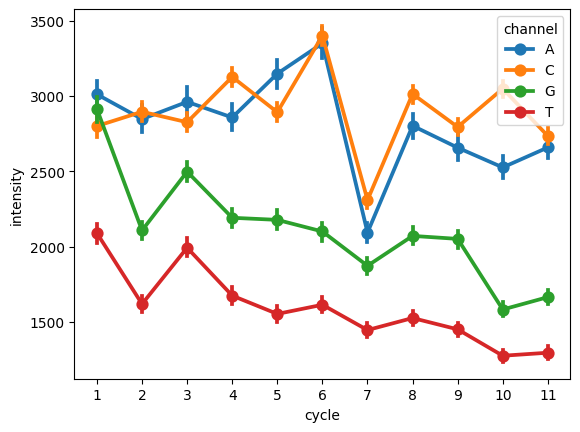

Intensity for each base:


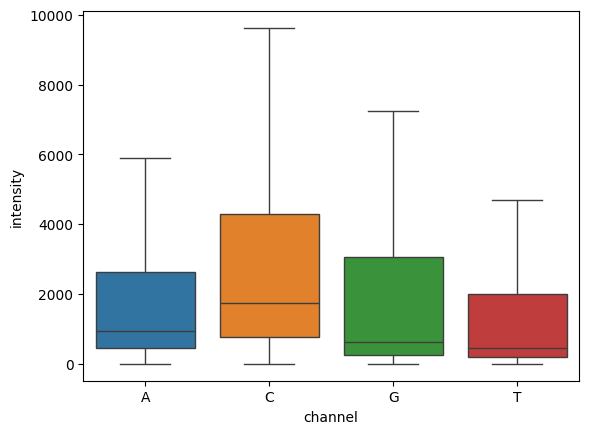

Calling reads...


read  cell     i     j  tile well      barcode  Q_0      Q_1      Q_2  \
0          0     0     5   455    50   A1  AACCACCCGGG  0.0  0.00000  0.00000   
44         1     0     5   601    50   A1  AACCACCCGGG  0.0  0.00000  0.00000   
88         2     0     5   685    50   A1  AACATCTTGGG  1.0  0.00000  0.87085   
132        3     0     5   722    50   A1  AACATCTTGGG  1.0  0.00000  1.00000   
176        4     0     5  1213    50   A1  TACTCCTCGGG  1.0  0.00000  1.00000   
...      ...   ...   ...   ...   ...  ...          ...  ...      ...      ...   
413072  9388  4032  1463   468    50   A1  TAATGCAAACC  1.0  0.73814  0.00000   
414260  9415  4032  1466   460    50   A1  TAATGTAAGTC  1.0  1.00000  1.00000   
415008  9432  4032  1468   465    50   A1  TAATGTAAGTC  1.0  1.00000  1.00000   
414436  9419  4033  1466  1156    50   A1  TATTAGGTAAC  1.0  1.00000  1.00000   
416152  9458  4033  1472  1153    50   A1  TATTAGGTAAC  1.0  1.00000  1.00000   

             Q_3      Q_4       Q_5       Q_6       Q_7       Q_8       Q_9  \
0       0.345825  0.00000  0.158436  0.000000  0.276692  0.203511  1.000000   
44      0.415037  0.00000  0.415037  0.415037  0.415037  0.415037  1.000000   
88      1.000000  1.00000  1.000000  1.000000  1.000000  0.738140  1.000000   
132     1.000000  1.00000  1.000000  1.000000  1.000000  0.000000  1.000000   
176     1.000000  1.00000  1.000000  1.000000  1.000000  1.000000  1.000000   
...          ...      ...       ...       ...       ...       ...       ...   
413072  0.773706  0.73814  0.000000  0.000000  0.000000  0.000000  0.738140   
414260  1.000000  1.00000  1.000000  1.000000  1.000000  1.000000  1.000000   
415008  1.000000  1.00000  1.000000  1.000000  1.000000  0.943358  1.000000   
414436  1.000000  1.00000  1.000000  0.870850  1.000000  1.000000  1.000000   
416152  1.000000  1.00000  0.870850  0.634788  0.870850  0.773706  0.415037   

           Q_10     Q_min         peak  
0       1.00000  0.000000   935.106456  
44      1.00000  0.000000   352.436282  
88      0.73814  0.000000  2010.987089  
132     1.00000  0.000000  2743.673715  
176     0.73814  0.000000   912.395240  
...         ...       ...          ...  
413072  0.73814  0.000000   320.526993  
414260  1.00000  1.000000  1883.564789  
415008  1.00000  0.943358  1049.846123  
414436  1.00000  0.870850  1430.395181  
416152  1.00000  0.415037  1102.576001  

[9469 rows x 20 columns]

Mapping rate vs. peak threshold for determining optimal peak cutoff:


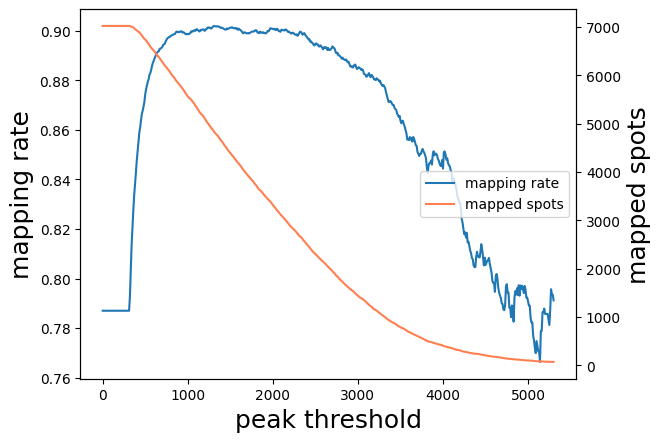

Mapping rate vs. Q_min for determining optimal sequence quality cutoff:


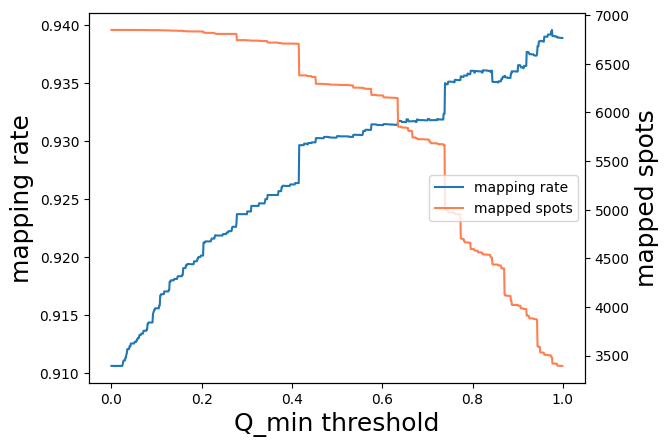

Annotating bases on SBS LoG...
Annotating bases on SBS read peaks (return reads)...
Annotating bases on SBS read peaks (return peaks)...
Corrected cells:


cell  tile well      Q_0  Q_1       Q_2      Q_3       Q_4  Q_5  \
0        1    50   A1  1.00000  1.0  0.634788  1.00000  1.000000  1.0   
1        2    50   A1  1.00000  0.0  1.000000  1.00000  1.000000  1.0   
2        3    50   A1  0.73814  1.0  1.000000  1.00000  0.738140  1.0   
3        4    50   A1  0.00000  1.0  0.000000  0.73814  0.738140  0.0   
4        5    50   A1  0.00000  1.0  0.000000  0.00000  0.738140  0.0   
...    ...   ...  ...      ...  ...       ...      ...       ...  ...   
3515  4026    50   A1  1.00000  1.0  1.000000  1.00000  0.773706  1.0   
3516  4027    50   A1  1.00000  1.0  1.000000  1.00000  1.000000  1.0   
3517  4029    50   A1  1.00000  1.0  1.000000  1.00000  1.000000  1.0   
3518  4032    50   A1  1.00000  1.0  1.000000  1.00000  1.000000  1.0   
3519  4033    50   A1  1.00000  1.0  1.000000  1.00000  1.000000  1.0   

          Q_6  ...  cell_barcode_count_0  cell_barcode_1  \
0     0.87085  ...                     1             NaN   
1     0.87085  ...                     1     AAAGACCGAAT   
2     1.00000  ...                     1             NaN   
3     0.73814  ...                     1             NaN   
4     0.00000  ...                     1             NaN   
...       ...  ...                   ...             ...   
3515  1.00000  ...                     2             NaN   
3516  1.00000  ...                     3             NaN   
3517  0.73814  ...                     1             NaN   
3518  1.00000  ...                     3     TAATGCAAACC   
3519  0.87085  ...                     2             NaN   

      cell_barcode_count_1  barcode_count               sgRNA_0  \
0                      0.0              1  ACGAGCGCGCCGAGTTCGAG   
1                      1.0              2  AGAGACCGAATAGGCACAGG   
2                      0.0              1  CTTACCTTGGAAGTGGACGT   
3                      0.0              1                   NaN   
4                      0.0              1                   NaN   
...                    ...            ...                   ...   
3515                   0.0              2  TAATGTAAGTCATGTTAGTG   
3516                   0.0              3  CACCATAGTTCCGGACCCCG   
3517                   0.0              1  CTGGGGTCGCTAATCCCTGA   
3518                   1.0              4  TAATGTAAGTCATGTTAGTG   
3519                   0.0              2  TATTAGGTAACCAATGGTCA   

      gene_symbol_0  gene_id_0 sgRNA_1  gene_symbol_1 gene_id_1  
0            RGS9BP     388531     NaN            NaN       NaN  
1            SMURF2      64750     NaN            NaN       NaN  
2               AGT        183     NaN            NaN       NaN  
3               NaN        NaN     NaN            NaN       NaN  
4               NaN        NaN     NaN            NaN       NaN  
...             ...        ...     ...            ...       ...  
3515          STIP1      10963     NaN            NaN       NaN  
3516           BCAN      63827     NaN            NaN       NaN  
3517            CPD       1362     NaN            NaN       NaN  
3518          STIP1      10963     NaN            NaN       NaN  
3519          SPAG9       9043     NaN            NaN       NaN  

[3520 rows x 28 columns]

Minimal phenotype features:


area            i            j  cell                    bounds  tile  \
0      117     7.299145   222.059829     1         (1, 217, 14, 228)    50   
1       80     6.450000   353.650000     2         (2, 349, 12, 359)    50   
2       86     8.976744   252.883721     3         (3, 249, 16, 258)    50   
3      105     7.447619   642.257143     4         (3, 636, 13, 649)    50   
4       94     9.265957   616.744681     5         (4, 611, 15, 623)    50   
...    ...          ...          ...   ...                       ...   ...   
4028    94  1468.744681   256.053191  4029    (1464, 251, 1475, 262)    50   
4029    69  1468.376812   644.246377  4030    (1464, 640, 1474, 649)    50   
4030    74  1468.540541   914.040541  4031    (1464, 910, 1474, 919)    50   
4031    70  1468.314286   463.400000  4032    (1465, 459, 1473, 469)    50   
4032    66  1470.621212  1157.000000  4033  (1466, 1153, 1476, 1162)    50   

     well  
0      A1  
1      A1  
2      A1  
3      A1  
4      A1  
...   ...  
4028   A1  
4029   A1  
4030   A1  
4031   A1  
4032   A1  

[4033 rows x 7 columns]

Summary of the fraction of cells mapping to one barcode:


well  tile  fraction of cells mapping to 1 barcode
0   A1    50                                 0.68733

Summary of the fraction of cells mapping to any barcode:


well  tile  fraction of cells mapping to >=1 barcode
0   A1    50                                  0.774362

Histogram of the number of reads per cell:


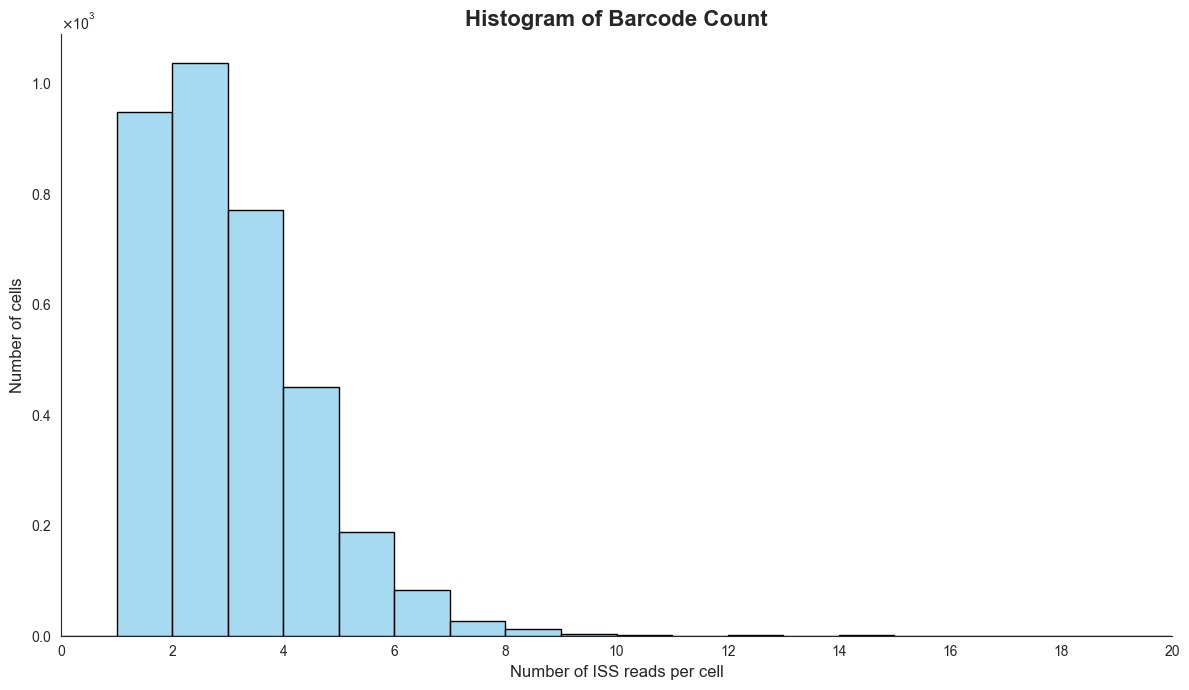

Histogram of the number of counts of each unique gene symbols:
gene_symbol_0
nontargeting    44
PFDN4           20
DTX2            15
HDGFL2          14
CARD10          13
                ..
ORC1             1
EIF2AK4          1
MIB1             1
TP53TG3C         1
SPAG9            1
Name: count, Length: 879, dtype: int64


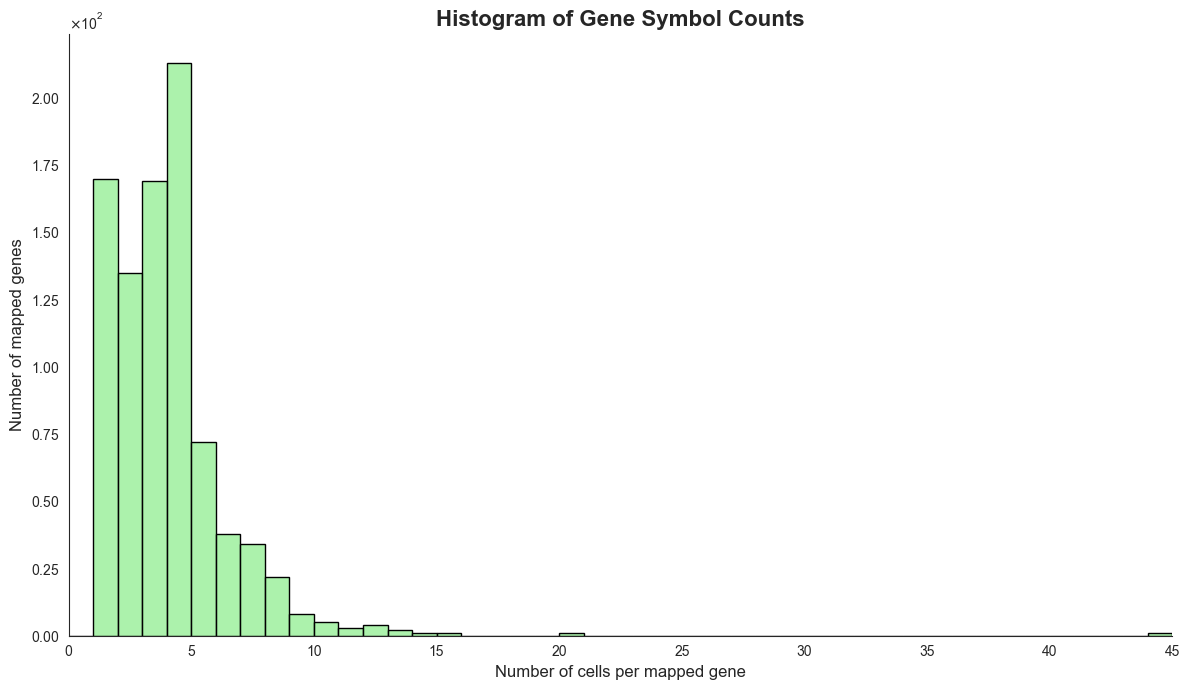

In [8]:
# Read and format guide data
df_design = pd.read_csv(DF_DESIGN_PATH)
df_pool = df_design.query("dialout==[0,1]").drop_duplicates("sgRNA")
df_pool["prefix"] = df_pool.apply(
    lambda x: x.sgRNA[: x.prefix_length], axis=1)  # 13
barcodes = df_pool["prefix"]

print("Extracting bases...")
df_bases = Snake_sbs._extract_bases(maxed, peaks, cells, THRESHOLD_READS, wildcards=WILDCARDS, bases=BASES)
df_bases.to_csv(name(description, tag='bases', ext='csv', subdir=OUTPUT_FILES_DIR), index=None)
display(df_bases)

print("Base intensity across cycles:")
ax = sns.pointplot(x="cycle", y="intensity", hue="channel", data=df_bases)
plt.show()

print("Intensity for each base:")
ax = sns.boxplot(x="channel", y="intensity", hue="channel", data=df_bases, showfliers=False)
plt.show()

print("Calling reads...")
df_reads = Snake_sbs._call_reads(df_bases, peaks=peaks)
df_reads.to_csv(name(description, tag='reads', ext='csv', subdir=OUTPUT_FILES_DIR), index=None)
display(df_reads)

print("Mapping rate vs. peak threshold for determining optimal peak cutoff:")
plot_mapping_vs_threshold(df_reads, barcodes, "peak")
plt.show()

print("Mapping rate vs. Q_min for determining optimal sequence quality cutoff:")
plot_mapping_vs_threshold(df_reads, barcodes, "Q_min")
plt.show()

# Make alternate annotation tif images
print("Annotating bases on SBS LoG...")
annotated_bases=Snake_sbs._annotate_bases_on_SBS_log(loged, df_reads)
save(name(description, tag='annotated_bases', subdir=OUTPUT_FILES_DIR), annotated_bases)
print("Annotating bases on SBS read peaks (return reads)...")
annotated_reads=Snake_sbs._annotate_bases_on_SBS_reads_peaks(loged, peaks, df_reads, df_pool, SBS_CYCLES, shape=(1480, 1480), return_channels="reads")
save(name(description, tag='annotated_reads', subdir=OUTPUT_FILES_DIR), annotated_reads)
print("Annotating bases on SBS read peaks (return peaks)...")
annotated_peaks=Snake_sbs._annotate_bases_on_SBS_reads_peaks(loged, peaks, df_reads, df_pool, SBS_CYCLES, shape=(1480, 1480), return_channels="peaks")
save(name(description, tag='annotated_peaks', subdir=OUTPUT_FILES_DIR), annotated_peaks)

print("Corrected cells:")
df_cells = Snake_sbs._call_cells(df_reads, df_pool=df_pool, q_min=Q_MIN)
df_cells.to_csv(name(description, tag='cells', ext='csv', subdir=OUTPUT_FILES_DIR), index=None)
display(df_cells)

print("Minimal phenotype features:")
df_sbs_info = Snake_sbs._extract_phenotype_minimal(data_phenotype=nuclei, nuclei = nuclei, wildcards=WILDCARDS)
df_sbs_info.to_csv(name(description, tag='sbs_info', ext='csv', subdir=OUTPUT_FILES_DIR), index=None)
display(df_sbs_info)

print("Summary of the fraction of cells mapping to one barcode:")
one_barcode_mapping = plot_cell_mapping_heatmap(df_cells, df_sbs_info, barcodes, mapping_to='one', mapping_strategy='gene_symbols', shape='6W_sbs', return_plot=False, return_summary=True)
display(one_barcode_mapping)

print("Summary of the fraction of cells mapping to any barcode:")
any_barcode_mapping = plot_cell_mapping_heatmap(df_cells, df_sbs_info, barcodes, mapping_to='any', mapping_strategy='gene_symbols', shape='6W_sbs', return_plot=False, return_summary=True)
display(any_barcode_mapping)

print("Histogram of the number of reads per cell:")
outliers = plot_reads_per_cell_histogram(df_cells, x_cutoff = 20)
plt.show()

print("Histogram of the number of counts of each unique gene symbols:")
outliers = plot_gene_symbol_histogram(df_cells, x_cutoff = 45)
plt.show()